<a href="https://colab.research.google.com/github/lankapadma/FMML-Module-5-Project/blob/main/FMML_Module_9_Lab4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Module 9: Convolutional Neural Networks
## **Lab 4**
### Module coordinator: Kushagra Agarwal

<img src="https://miro.medium.com/max/1200/1*QoqNAg2t6lF8Q6WWA6AbOg.png" width=650px/>

## Using learnt representations
In practice, very few people train an entire Convolutional Network from scratch (with random initialization), because it is relatively rare to have a dataset of sufficient size. Instead, it is common to pretrain a ConvNet on a very large dataset (e.g. ImageNet, which contains 1.2 million images with 1000 categories), and then use the ConvNet either as an initialization or a fixed feature extractor for the task of interest.


We'll train a model to classify ants and bees. We have about 120 training images each for ants and bees. There are 75 validation images for each class. Usually, this is a very small dataset to generalize upon, if trained from scratch. Since we are using transfer learning, we should be able to generalize reasonably well.

This dataset is a very small subset of imagenet.




In [1]:
# Import packages
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, SubsetRandomSampler
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np
import time
import os

In [2]:
# Device configuration (whether to run on GPU or CPU)
device = 'cpu' #torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# Download and extract dataset
!wget https://download.pytorch.org/tutorial/hymenoptera_data.zip
!unzip -q hymenoptera_data.zip

--2024-05-07 11:36:59--  https://download.pytorch.org/tutorial/hymenoptera_data.zip
Resolving download.pytorch.org (download.pytorch.org)... 18.239.83.126, 18.239.83.32, 18.239.83.16, ...
Connecting to download.pytorch.org (download.pytorch.org)|18.239.83.126|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47286322 (45M) [application/zip]
Saving to: ‘hymenoptera_data.zip’

hymenoptera_data.zi 100%[===================>]  45.10M   192MB/s    in 0.2s    

2024-05-07 11:37:00 (192 MB/s) - ‘hymenoptera_data.zip’ saved [47286322/47286322]



In [4]:
# Data augmentation and normalization for training
# Just normalization for validation
train_transform = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
val_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

data_dir = './hymenoptera_data'
train_dataset = ImageFolder(os.path.join(data_dir, 'train'), train_transform)
val_dataset = ImageFolder(os.path.join(data_dir, 'val'), val_transform)
train_dataloader = DataLoader(train_dataset, batch_size=4,shuffle=True, num_workers=2)
val_dataloader = DataLoader(val_dataset, batch_size=4,shuffle=True, num_workers=2)
class_names = train_dataset.classes


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


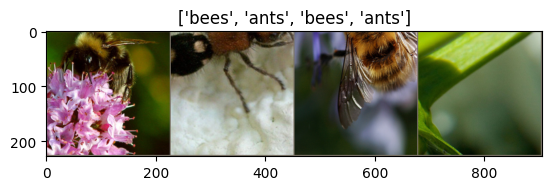

In [5]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(train_dataloader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [6]:
def train_model(model, train_dataloader, criterion, optimizer, num_epochs=25):

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)
        model.train()
        running_loss = 0.0
        running_corrects = 0

        # Iterate over data.
        for i, (inputs, labels) in enumerate(train_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            # track history if only in train
            with torch.set_grad_enabled(True):
              outputs = model(inputs)
              _, preds = torch.max(outputs, 1)
              loss = criterion(outputs, labels)

              # backward + optimize only if in training phase
              loss.backward()
              optimizer.step()

            # statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(train_dataloader.dataset)
        epoch_acc = running_corrects.double() / len(train_dataloader.dataset)

        print(f'Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        print()

In [7]:
def visualize_model(model, num_images=10):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(val_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [8]:
from torchvision import models

model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

loss_func = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 149MB/s]


In [9]:
num_epochs = 5
train_model(model_ft, train_dataloader, loss_func, optimizer, num_epochs)

Epoch 0/4
----------
Loss: 0.5327 Acc: 0.7172

Epoch 1/4
----------
Loss: 0.4935 Acc: 0.7910

Epoch 2/4
----------
Loss: 0.7964 Acc: 0.7131

Epoch 3/4
----------
Loss: 0.5802 Acc: 0.7951

Epoch 4/4
----------
Loss: 0.5701 Acc: 0.7951



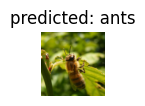

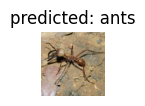

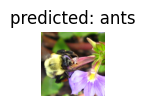

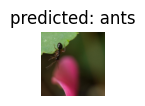

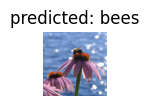

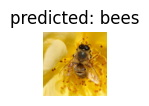

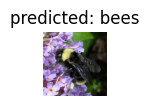

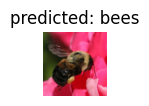

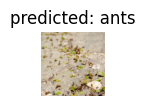

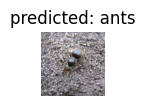

In [10]:
visualize_model(model_ft)

## Example of How Pretrained models are used for Target Tasks

<img src="https://www.researchgate.net/publication/340225334/figure/fig2/AS:960014822944773@1605896778155/Mechanism-of-transfer-learning-using-pre-trained-models.png" width=950px/>

## Questions:
1) What is the significance of using data augmentations like resize, crop etc on training data?

2) What performance do you get if you don't use pretrained resnet model (Hint: Change pretrained=False and train the model)

3) If the resnet model was pre-trained on dataset significantly different than the ants vs bees data, would you still get good performance by using this pretrained model?


answer 3
The effectiveness of using a pre-trained ResNet model on a different dataset, such as the ants vs. bees dataset, depends on several factors:

Domain Similarity: If the pre-trained model was trained on a dataset that is significantly different from the ants vs. bees dataset in terms of domain, content, or characteristics (e.g., medical images vs. natural images), the performance might be compromised. Pre-trained models are most effective when the pre-training dataset is similar to the target dataset in terms of content and distribution.
Transferability of Features: Despite differences in datasets, lower layers of deep neural networks tend to learn generic features such as edges, textures, and basic shapes that are common across different domains. In contrast, higher layers capture more domain-specific features. If the lower layers have learned useful features that are relevant to the target dataset (e.g., identifying edges and textures in natural images), the pre-trained model can still provide a good starting point for transfer learning.
Fine-Tuning Strategy: Fine-tuning involves updating the parameters of the pre-trained model on the target dataset while keeping some of the learned features intact. Adjusting the fine-tuning strategy, such as the learning rate, number of layers to fine-tune, and data augmentation techniques, can help adapt the pre-trained model to the target dataset more effectively.
Amount of Training Data: The amount of labeled data available for fine-tuning also plays a crucial role. If the ants vs. bees dataset is small, fine-tuning a pre-trained model can still yield better performance compared to training from scratch, as the pre-trained model provides a good initialization point.
Task Complexity: The complexity of the classification task (e.g., distinguishing between ants and bees in images) also influences the transferability of features. If the task is conceptually similar to the task the pre-trained model was originally trained on, transfer learning is more likely to be effective.
In summary, while using a pre-trained ResNet model on a significantly different dataset may not guarantee optimal performance, it can still serve as a valuable starting point for transfer learning. Fine-tuning and adapting the pre-trained model to the target dataset, along with considerations of domain similarity and task complexity, are essential for achieving good performance.







answer 1
Data augmentation techniques like resizing, cropping, flipping, rotating, and adjusting brightness or contrast are crucial in training machine learning models, especially in computer vision tasks. Here's why they're significant:

Increased Variability: Augmentations create variations of the original data, which effectively expands the training dataset. This helps prevent overfitting by exposing the model to a wider range of scenarios it might encounter during deployment. By introducing diverse perspectives of the same object or scene, the model becomes more robust and generalizes better to unseen data.
Regularization: Data augmentation serves as a form of regularization, discouraging the model from relying too heavily on specific features or patterns in the training data. Instead of memorizing the exact details of each training sample, the model learns to focus on the underlying features that are invariant to the augmentation transformations.
Improved Generalization: By simulating real-world variations in the training data, augmentations help the model learn invariant representations of objects. For instance, a classifier trained on images that are randomly flipped horizontally will be more robust to changes in orientation. This enhances the model's ability to generalize across different conditions, such as changes in lighting, viewpoint, or object position.
Reduced Overfitting: Data augmentation introduces noise and perturbations to the training data, making it harder for the model to memorize specific instances. As a result, the model is less likely to overfit to the training data and can better generalize to unseen examples.
Balancing Classes: In classification tasks with imbalanced class distributions, augmentations can be used to generate synthetic samples for minority classes, thereby balancing the dataset and preventing the model from being biased towards the majority class.
Preprocessing: Augmentations can also serve as a form of preprocessing, allowing the model to learn features that are invariant to certain transformations. For example, resizing and cropping images to a fixed size ensure that the model receives inputs of consistent dimensions, which simplifies the training process.
Overall, data augmentation is a powerful technique for enhancing the performance and robustness of machine learning models, particularly in scenarios where labeled training data is limited or expensive to obtain. By generating diverse variations of the training data, augmentations enable models to learn more generalized and adaptive representations, ultimately improving their performance on unseen data.







answer 2
If you don't use a pre-trained ResNet model and instead train it from scratch on your dataset, the performance may vary depending on factors such as the size and complexity of your dataset, the amount of training data available, and the computational resources used for training. Training a deep neural network like ResNet from scratch typically requires a large amount of labeled data and significant computational power.

Without using pre-training, the model starts with random weights, and during training, it learns to extract meaningful features directly from the input data. This process can be more challenging and may require more data and training time compared to fine-tuning a pre-trained model.

The performance you achieve without using pre-training can be evaluated based on metrics such as accuracy, precision, recall, F1 score, or other task-specific evaluation measures. Typically, you would compare this performance against benchmarks or other models trained on the same dataset to assess its effectiveness.

To evaluate the performance, you would typically train the model on a training dataset, validate it on a separate validation set, and then assess its performance on a held-out test set to measure its generalization ability to unseen data. The performance metrics obtained from this process would indicate how well the model has learned to classify or predict outputs on your specific task.





